# Fitting a double-Wilson model to an anomalous dataset


# Introduction

Analogously to **notebook 3**, here we fit the double-Wilson (DW) model to real data that has been preprocessed in **notebook 1A**. After loading in the data and inspecting a few properties,
-  in the section **Calculating effective Rice dist parameters per reflection**, we fit a resolution-dependent $r$ to the data. The $r$ depends on both the $a$ and $b$ parameters in **notebook 2b**, as well as resolution-dependent measurement error. 
- in the section **Inspection of the $|E_1|$ and $|E_2|$ distributions**, we check the quality of the DW model fit by visually comparing histograms of the structure factor amplitudes (SFAs) $|E_1|$ and $|E_2|$ to the DW distribution. 
- in the section **Let's take a look at phases!**, we check that the phases follow the expected von Mises distribution (Bricogne, Methods in Enzymology (1997), eq. 1.10).

As before, we will use $r$ or $r_{DW}$ for the double-Wilson correlation parameter. 

## Importing modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy   as np
import pandas  as pd

In [2]:
import reciprocalspaceship as rs
import gemmi
from scipy.optimize  import least_squares, minimize
from scipy.stats     import rice, foldnorm, vonmises, linregress, pearsonr
from dw_tools        import fitting_dw, modify_ds

In [3]:
%autosave 300
# !cat /proc/meminfo | grep Mem
%load_ext autoreload
%autoreload 2
rs.__version__
    
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize':(5,3.5)})

Autosaving every 300 seconds


## Loading data

In [4]:
path="double_wilson_data/"    # Unix
ds1=rs.read_mtz(path + "NECAT_HEWL_RT_NaI/NECAT_HEWL_RT_NaI_82_XDS_scaled1_scaled.mtz")
# ds1.info()

In [5]:
modify_ds.ds_add_rs(ds1)
ds1.compute_dHKL(          inplace=True)
ds1.label_centrics(        inplace=True)
ds1.compute_multiplicity(  inplace=True)
(ds1, bin_labels) = \
ds1.assign_resolution_bins(inplace=True, return_labels=True);

# ds1.info()
# print(bin_labels)
EP1_label = "EP+_aniso_2"
EP2_label = "EP-_aniso_2"
dHKL_label = "dHKL"
dHKL_bin_label = "bin"

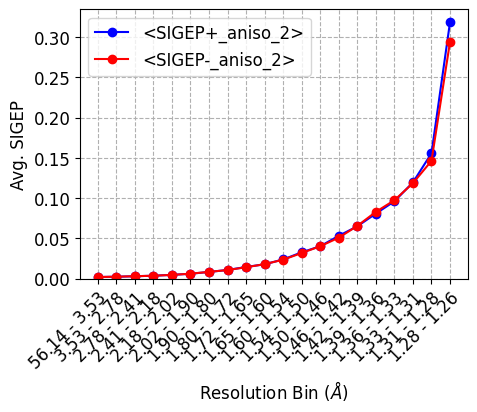

In [6]:
result = ds1.groupby(dHKL_bin_label)["SIG" + EP1_label].mean()
plt.plot(result,'bo-', label="<SIG" + EP1_label + ">")
result = ds1.groupby(dHKL_bin_label)["SIG" + EP2_label].mean()
plt.plot(result,'ro-', label="<SIG" + EP2_label + ">")
plt.xticks(result.index, bin_labels, rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel(r"Resolution Bin ($\AA$)")
plt.ylabel("Avg. SIGEP")
plt.grid(linestyle='--')
plt.ylim([0,plt.ylim()[1]]); plt.legend(); plt.show()

Optionally, apply a resolution cutoff.

In [7]:
if True:
    modify_ds.ds_high_res_cut(ds1, rescut=1.3, inplace=True)

In [8]:
# currently, the following is applied in 1A:
#   ds1 = ds1[(ds1["I(+)"]>=0) & (ds1["I(-)"]>=0)]
# plt.hist(ds1["IMEAN"],100)
# plt.show()

In [9]:
(a,b) = fitting_dw.fit_ab(ds1,labels=[EP1_label,EP2_label],\
                          dHKL_label=dHKL_label, dHKL_bin_label=dHKL_bin_label)
print(a)
print(f"a: {a:.4}")
print(f"b: {b:.4}")

`gtol` termination condition is satisfied.
Function evaluations 9, initial cost 7.2407e+00, final cost 6.8409e-01, first-order optimality 5.87e-16.
0.9999999999999998
a: 1.0
b: 1.487e-11


We generally find that $r\approx a \approx 1$ for anomalous data.

# Calculating effective Rice dist parameters per reflection
Consider two data sets of normalized structure factor amplitudes, $\{x\}$ and $\{x+\epsilon+\eta\}$, with the first data set ideal, $\epsilon$ the fixed, true differences between the data sets and $\eta$ the measurement errors. In this case, $\textrm{Cov}(x,x+\epsilon)$ is given by the double-Wilson distribution, as is $\sigma^2_{x}$. Once we've estimated $a$ and $b$ above such that $r(s)=a\cdot e^{-b s^2}$, we can calculate what value we should use to constrain a prior distribution for another data set by taking into account that our estimates are tainted by measurement error. 

To begin, we'll use the approximate relationship $\rho(|E_1|,|E_2|)=r_{DW}^2$ and the relationship

$\rho^{-2}_{obs}=\rho^{-2}_{DW} +\frac{\sigma^2_{\eta}}{\sigma^2_{x}}$,

with $\sigma_x$ known from the Wilson distribution and different between centric and acentric reflections. This equation follows from:

$\rho(x,x+\varepsilon+\eta) = \frac{\sigma_x}{\sqrt{\sigma^2_x+\sigma^2_{\epsilon}+\sigma^2_{\eta}}}$
and $\rho_{DW}=\rho(x,x+\varepsilon)=\frac{\sigma_x}{\sqrt{\sigma^2_x+\sigma^2_{\epsilon}}}$

Now,

$r_{eff}\approx\sqrt{\rho_{obs}}$   and   $\rho_{obs}=1/\sqrt{\rho^{-2}_{DW} +\frac{\sigma^2_{\eta}}{\sigma^2_{x}}}$   and   $\rho_{DW}\approx a^2 e^{-2bs^2}$ and $s=1/d_{HKL}$.

In [10]:
# a=0.995
# b=0.1
fitting_dw.eff_r_dw_per_hkl(ds1,a,b,label=EP1_label, dHKL_label=dHKL_label, inplace=True);
fitting_dw.eff_r_dw_per_hkl(ds1,a,b,label=EP2_label, dHKL_label=dHKL_label, inplace=True);

In [11]:
# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# plt.scatter(ds1["r_DW_out_EP+_aniso_2"],ds1["r_DW_out_EP-_aniso_2"],alpha=0.01)
# plt.xlabel("r_DW (EP(+))"); plt.ylabel("r_DW (EP(-))")

# plt.subplot(1,2,2)
# plt.hist(ds1["r_DW_out_EP+_aniso_2"],np.linspace(0,1,500),alpha=0.6, label="EP(+) (aniso2)")
# plt.hist(ds1["r_DW_out_EP-_aniso_2"],np.linspace(0,1,500),alpha=0.6, label="EP(-) (aniso2)")
# plt.xlabel("r_DW"); plt.ylabel("Count")
# plt.xlim((0.8,1))
# plt.show()

**~ ~ At this point, we're really done. ~ ~**

What follows is additional some inspection.

# Inspection of the $|E_1|$ and $|E_2|$ distributions
Here we look at the conditional probability distributions for $|E_2|$ given that $|E_1|$ falls in some narrow bin of values. We will see that the conditional histograms are well approximated by Rice and folded normal distributions for the acentric and centric cases, respectively. That is, the joint distribution of structure factor amplitudes is well-described by the double-Wilson or bivariate Wilson distribution.

## Binning by $|E_1|$
We compute means per bin for $|E_1|$, determined separately for acentrics and centrics.
We will calculate the conditional distributions of $|E_2|$ per bin of $|E_1|$. We'll set bin labels for both centrics and acentrics here:

In [12]:
nbin=25
cdf_bins = np.linspace(0,100,nbin+1)

ds1_centric  = (ds1["CENTRIC"].to_numpy()==True)
ds1_acentric = (ds1["CENTRIC"].to_numpy()==False)

ep1_bins          = np.percentile(ds1.loc[ds1_acentric, EP1_label], cdf_bins)
ep1_bins[-1]      = ep1_bins[-1]+1e-6                # to avoid omitting the largest data point
ep1_dig           = np.digitize(ds1.loc[  ds1_acentric, EP1_label], ep1_bins) # note that we're creating bin labels for all reflections, acentric or not

ep1_cent_bins     = np.percentile(ds1.loc[ds1_centric,  EP1_label], cdf_bins)
ep1_cent_bins[-1] = ep1_cent_bins[-1]+1e-6
ep1_cent_dig      = np.digitize(ds1.loc[  ds1_centric,  EP1_label], ep1_cent_bins) # note that we're creating bin labels for all reflections, acentric or not

ds1.loc[ds1_acentric, "EP_1_bin"] = ep1_dig.flatten()
ds1.loc[ds1_centric,  "EP_1_bin"] = ep1_cent_dig.flatten()

Some inspection of the created bins!

Number of reflections per bin (acentric):
{1.0: 1061, 2.0: 1061, 3.0: 1061, 4.0: 1060, 5.0: 1061, 6.0: 1061, 7.0: 1060, 8.0: 1061, 9.0: 1061, 10.0: 1060, 11.0: 1061, 12.0: 1061, 13.0: 1060, 14.0: 1061, 15.0: 1061, 16.0: 1060, 17.0: 1061, 18.0: 1061, 19.0: 1060, 20.0: 1061, 21.0: 1061, 22.0: 1060, 23.0: 1061, 24.0: 1061, 25.0: 1061}

Number of reflections per bin (centric):
{1.0: 152, 2.0: 152, 3.0: 152, 4.0: 152, 5.0: 152, 6.0: 152, 7.0: 151, 8.0: 152, 9.0: 152, 10.0: 152, 11.0: 152, 12.0: 152, 13.0: 151, 14.0: 152, 15.0: 152, 16.0: 152, 17.0: 152, 18.0: 152, 19.0: 151, 20.0: 152, 21.0: 152, 22.0: 152, 23.0: 152, 24.0: 152, 25.0: 152}


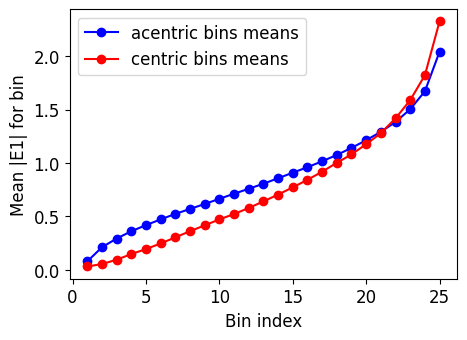

In [13]:
# For acentrics:
unique, counts = np.unique(ds1.loc[ds1_acentric, "EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):"); print(temp)
print()

# for centrics
unique, counts = np.unique(ds1.loc[ds1_centric, "EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (centric):");  print(temp)

bin_means_acentric = ds1[ds1_acentric].groupby("EP_1_bin")[EP1_label].mean()
bin_means_centric  = ds1[ds1_centric ].groupby("EP_1_bin")[EP1_label].mean()
plt.plot(bin_means_acentric,'bo-',label="acentric bins means")
plt.plot(bin_means_centric, 'ro-',label="centric bins means")
plt.xlabel("Bin index"); plt.ylabel("Mean |E1| for bin")
plt.legend(); plt.show()

## Conditional distribution for Acentrics. Histograms of $|E_2|$ per bin of $|E_1|$.
**Note**: this does not yet use the $a$ and $b$ estimated above.

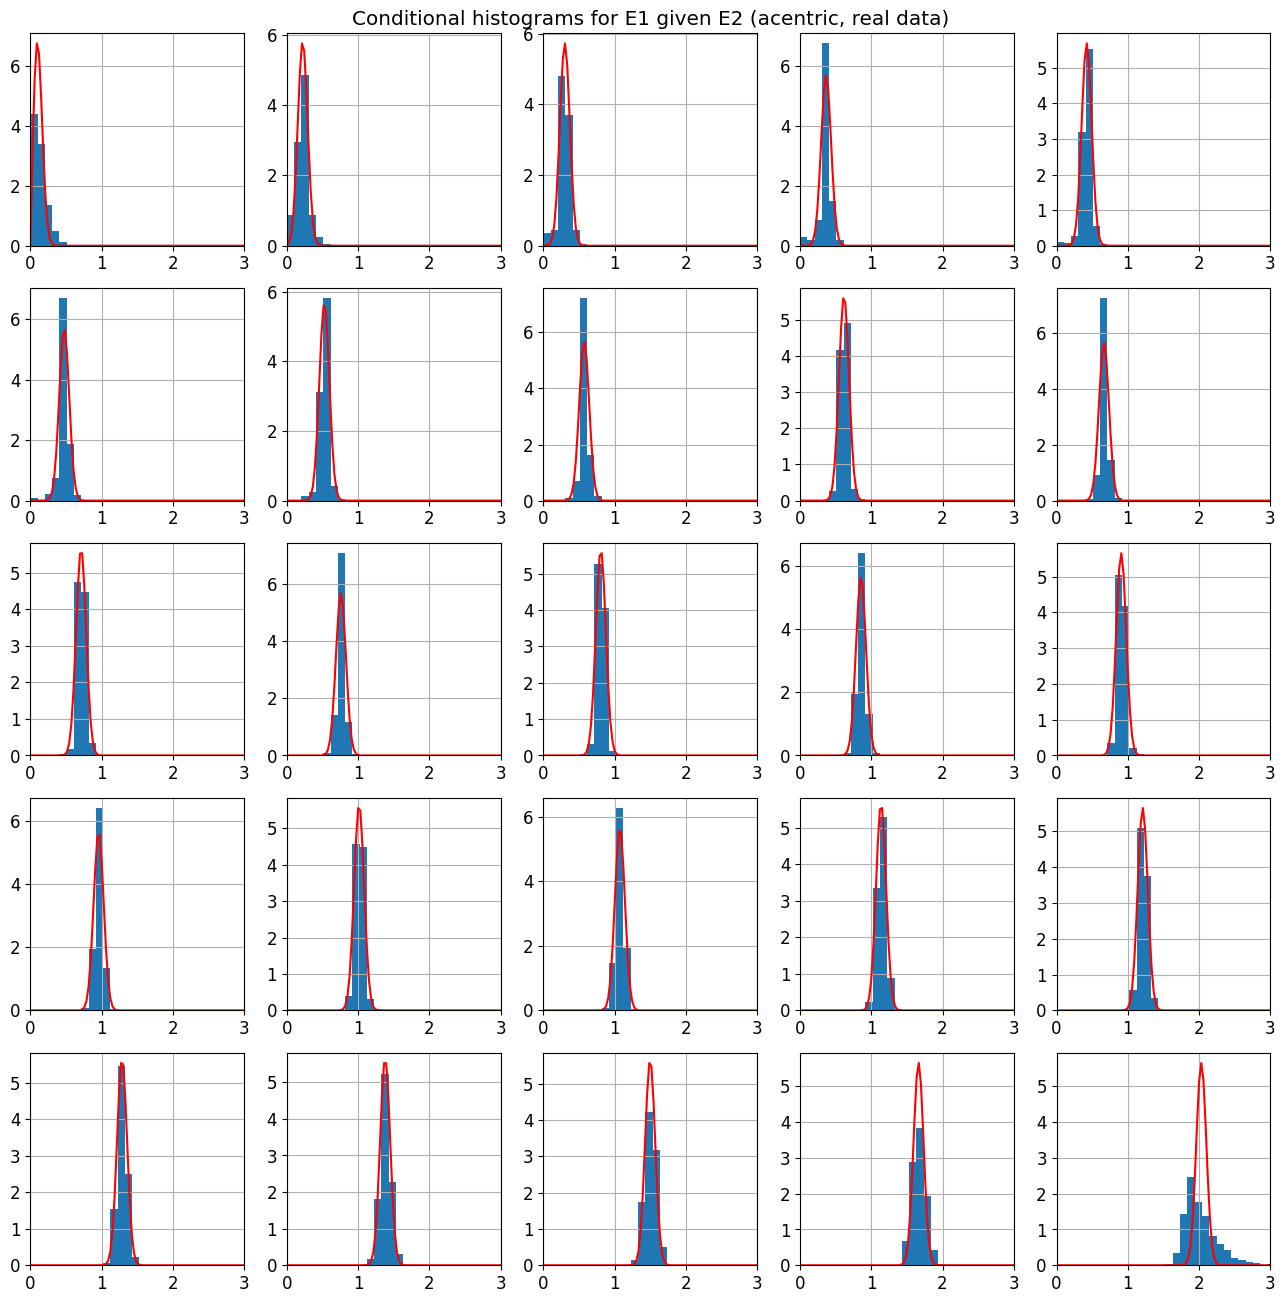

In [14]:
plt.figure(figsize=(16,16))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = np.amin([0.995,a])                    # a guess of the corr coef between data sets
    r1  = rho*bin_means_acentric[i]  # conditional exp value of E1 given E2
    cond_var = 0.5*(1-rho**2)        # conditional variance  of E1 given E2
#    
    plt.hist(ds1.loc[(ds1["EP_1_bin"]==i) & ds1_acentric, EP2_label],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl); plt.grid()

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (acentric, real data)")
plt.show()

The conditional distribution for acentrics fits the real data well. Let's do a closer inspection of a few $|E_1|$ bins, as we did in **notebook 2a**. 

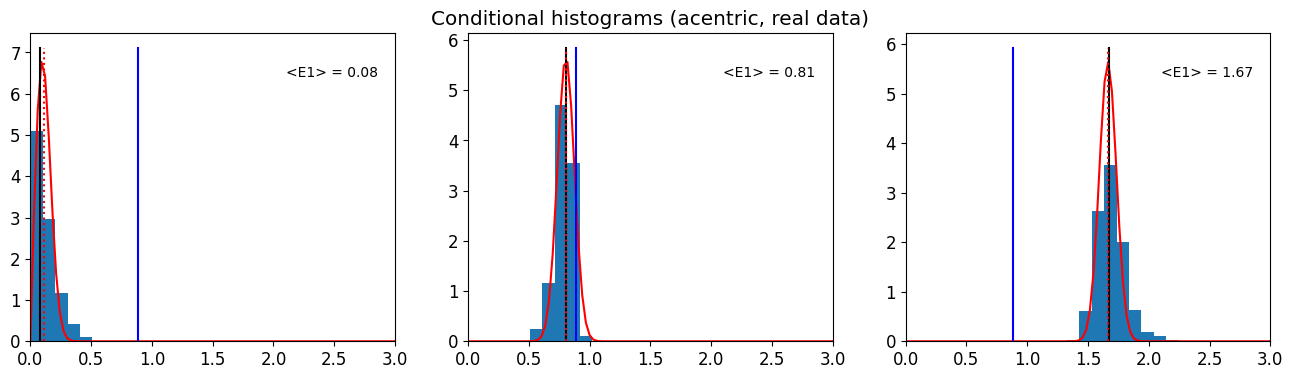

In [15]:
plt.figure(figsize=(16,4))
x=np.linspace(0,3,100)
counter = 0
for i in [1, 13, 24]:
    counter += 1             # for illustration purposes.
    plt.subplot(1,3,counter) # for illustration purposes.
    r_DW = np.amin([0.995,a])
    r1 = r_DW*bin_means_acentric[i]     # conditional exp value
    cond_var = 0.5*(1-r_DW**2) # conditional var for acentrics
    
    plt.hist(ds1.loc[ds1["EP_1_bin"]==i,EP2_label],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    yl=plt.ylim()

#    to illustrate the idea of Rice interpolating between Wilson and delta function:
    plt.plot(bin_means_acentric[i]*np.asarray([1, 1]),yl,'k-')
    plt.plot(rice.mean(0,scale=1/np.sqrt(2))*np.asarray([1,1]),yl,'b-')
    plt.plot(rice.mean(r1/np.sqrt(cond_var),scale=np.sqrt(cond_var))*np.asarray([1,1]),yl,'r:')
    xl=[0,3] #plt.xlim()
    plt.text(2.1,0.9*yl[1],f"<E1> = {bin_means_acentric[i]:.2f}",size=10)
    plt.xlim(xl)
    if counter == 2:
        plt.title("Conditional histograms (acentric, real data)")
 
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

## Conditional distribution for Centrics. Histograms of $|E_2|$ per bin of $|E_1|$.

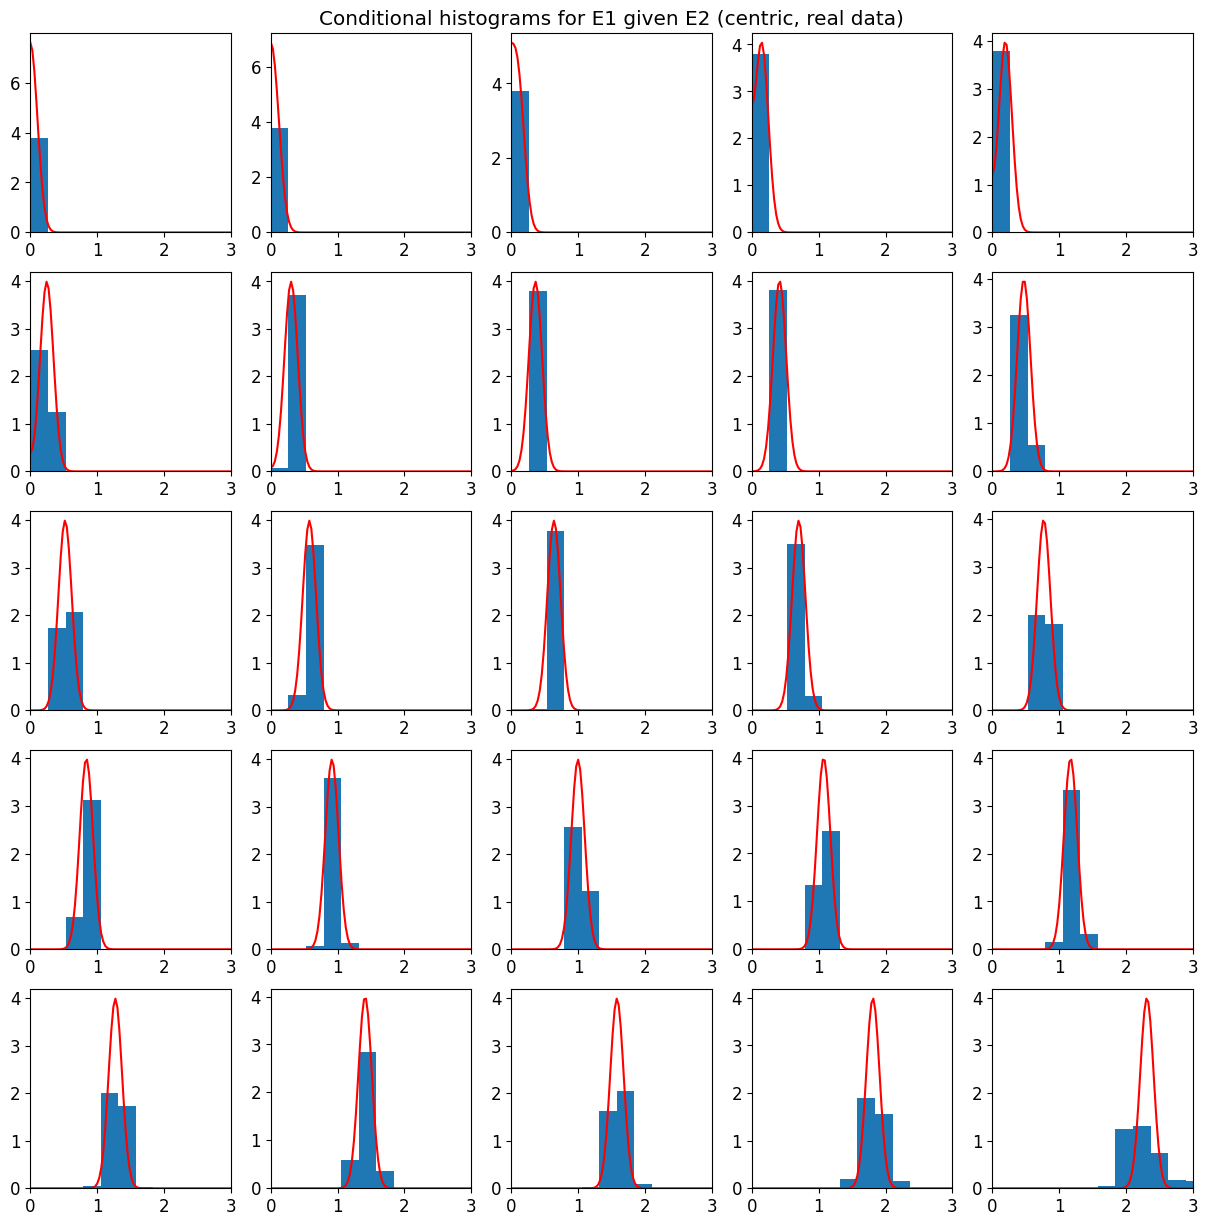

In [16]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = np.amin([0.995,a])                        # a guess of the corr coef between data sets
    r1  = rho*bin_means_centric[i]   # conditional exp value of E1 given E2
    cond_var = (1-rho**2)            # conditional variance  of E1 given E2
#    
    plt.hist(ds1.loc[(ds1["EP_1_bin"]==i) & ds1_centric,EP2_label],np.linspace(0,5,20),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (centric, real data)")
plt.show()

There are not that many centric reflections, but they fit the model well. 